In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [4]:
def julia(R, eps, bound = 4, z0 = -1-1j, z1 = 1+1j, niter = 20, halo = False):

    X = np.arange(np.real(z0), np.real(z1), eps)
    Y = np.arange(np.imag(z0), np.imag(z1), eps)

    C = []

    for x in X:
        C.append([])
        for y in Y:

            flag = 0;
            z0 = x+y*1j
            for i in range(niter):
                z0 = R(z0)
                if(np.abs(z0)>bound):
                    flag = halo*i+1;
                    break
            C[-1].append(flag)
    return np.array(C)

def convolve(C, kernel = np.array([[0,1,0], [1, 4, 1], [0, 1, 0]])):

    dict = {
        "blur":np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]]),
        "sharpen":np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
        "left_edge":np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]),
        "right_edge":-np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    }

    if(type(kernel)==str):
        kernel = dict[kernel]

    w = len(C[0])
    h = len(C)

    step = len(kernel)//2
    new = np.ndarray.tolist(C[:step])

    for i in range(step, h-step):
        new.append(np.ndarray.tolist(C[i][:step]))
        for j in range(step, w-step):
            new[-1].append(sum(sum(C[i-step:i+step+1][:,j-step:j+step+1] * kernel)))
        new[-1].extend(C[i][-step:])
    
    new.extend(np.ndarray.tolist(C[-step:]))
    return np.array(new)

In [140]:
def R(z): #0.35-0.45 for blob convergence, 0.35-0.5 pretty, -0.4-0.6j for blob convergence and possible self similarity
    return (z**2-0.4-0.6j)

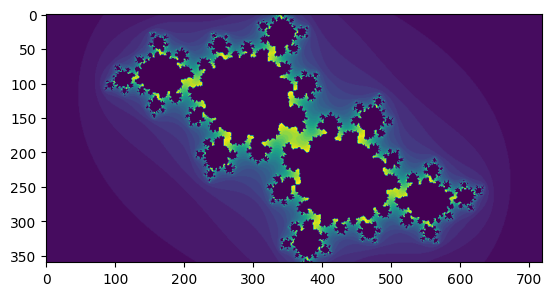

In [165]:
C = julia(R, 0.005, bound=2, z0=-1.8-0.9j, z1 = 1.8+0.9j, niter=30, halo=True)
plt.imshow(C.T)

### Detecting Blobs

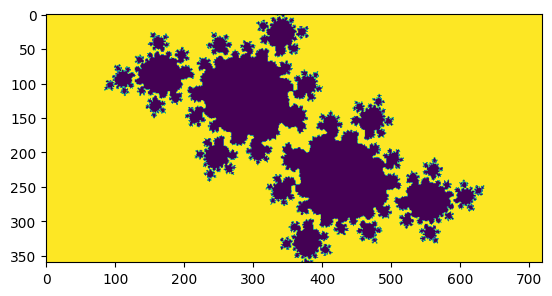

In [190]:
z0 = -1.8-0.9j
z1 = 1.8+0.9j
eps = 0.005

C = julia(R, eps, bound=2, z0=z0, z1 = z1, niter=30, halo=False)

X = np.arange(np.real(z0), np.real(z1), eps)
Y = np.arange(np.imag(z0), np.imag(z1), eps)

plt.imshow(C.T)

In [192]:
def binaryEdge(C):
    edgeCoords = []

    for i in range(1, len(C)-1):
        for j in range(1, len(C[0])-1):
            if not (C[i-1:i+1+1][:,j-1:j+1+1].reshape(9)==C[i][j]).all():
                edgeCoords.append((i,j))
    return edgeCoords

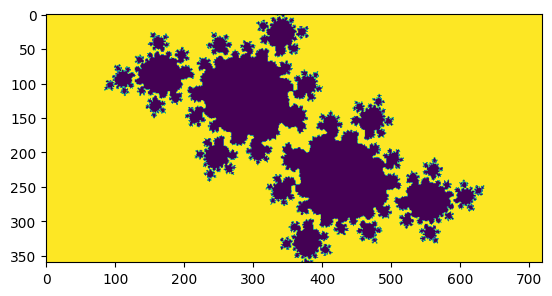

In [193]:
plt.imshow(C.T)

In [194]:
def expand(D, point, checked):


    x = point[0]
    y = point[1]

    checked[x][y] = True

    for i in range(x-1, x+2):
        for j in range(y-1, y+2):
            if not D[i][j] and not checked[i][j]:
                expand(D, (i,j), checked)
    return

def points(D):
    pointArr = []

    checked = np.zeros((len(D), len(D[0])))
    for i in range(len(checked)):
        checked[i][0] = 1;
        checked[i][-1]=1;
    for i in range(len(checked[0])):
        checked[0][i] = 1;
        checked[-1][i] = 1;

    for i in range(1, len(D)-1):
        for j in range(1, len(D[0])-1):
            if not D[i][j] and not checked[i][j]:
                pointArr.append((i,j))
                expand(D, (i,j), checked)
    return pointArr

In [195]:
sys.setrecursionlimit(1000000)
result = points(C)

In [183]:
def coordToIndex(xarr, yarr, x, y):
    return (len(xarr)-np.argmax(xarr[::-1]<=x), len(yarr)-np.argmax(yarr[::-1]<=y))

def indexToCoord(xarr, yarr, i, j):
    return (xarr[i], yarr[j])

In [196]:
D = C

In [197]:
niter = 1
for itr in range(niter):
    for k in range(len(result)):
        p = result[k]
        i = p[0]
        j = p[1]
        if i>=len(D) or j>=len(D[0]):
            i = len(D)-1
            j = len(D[0])-1

        D[i][j] = 2+itr/niter

        x,y = indexToCoord(X, Y, i, j)

        z = R(x+1j*y)
        x = np.real(z)
        y = np.imag(z)

        result[k] = coordToIndex(X, Y, x, y)

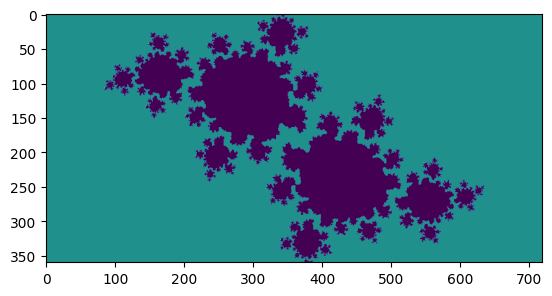

In [198]:
plt.imshow(D.T)